In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import json
from PIL import Image
from collections import Counter
import pickle
import shutil
from shapely.geometry import Polygon

In [2]:
base_path = '..'
generate_all_datset_annots = True
generate_pseudo_labels = True
keep_all_in_train = False
tile_categories = ['blood_vessel']
base_data_dir = 'dataset1_files' if not generate_all_datset_annots else 'all_dataset_files'
base_data_name = 'all_dataset1' if not generate_all_datset_annots else 'all_dataset'
pseudo_label_name = '' if not generate_pseudo_labels else '_pseudo_labels'

In [3]:
num_folds = 2
input_imgs_path = f'{base_path}/train'

for i in range(num_folds):
    output_dir = f'{base_path}/{base_data_dir}/{base_data_name}{pseudo_label_name}_mmdet_fold_{i}'
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)
    os.mkdir(f'{output_dir}/train_images')
    os.mkdir(f'{output_dir}/validation_images')
    os.mkdir(f'{output_dir}/annotations')

In [4]:
def get_count_type(tiles_dict):
  ids_with_info = []
  for tile in tiles_dict:
    cur_dict = {'id': tile['id'], 'blood_vessel': 0, 'glomerulus': 0, 'unsure': 0}
    for annot in tile['annotations']:
      cur_dict[annot['type']] += 1
    ids_with_info.append(cur_dict)
  return ids_with_info
def calculate_area(coords):
    p = Polygon(coords)
    return p.area
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(30, 30))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
def create_category_annots(tile_categories):
    categories = []
    for idx, tc in enumerate(tile_categories):
        categories.append({'id': idx, 'name': tc})
    return categories
def create_image_annots(input_imgs_names):
    image_annots = []
    img_name_to_id = dict()
    input_img_names = sorted(input_imgs_names)
    for idx, img_name in enumerate(input_img_names):
        img = cv2.imread(f'{input_imgs_path}/{img_name}.tif')
        height, width = img.shape[:2]
        image_annots.append({'file_name': f'{img_name}.tif', 'height': height, 'width': width, 'id': idx})
        img_name_to_id[img_name] = idx
    return image_annots, img_name_to_id
def create_seg_annots(tgt_tile_dicts, img_name_to_id):
    annotations = []
    annot_id = 0
    for tile_dict in tgt_tile_dicts:
        cur_img_name = tile_dict['id']
        cur_annots = tile_dict['annotations']
        for annot in cur_annots:
            if annot['type'] not in tile_categories:
                continue
            coords = annot['coordinates'][0]
            segmentation = [[pt for pair in coords for pt in pair]]
            area = calculate_area(coords)
            image_id = img_name_to_id[cur_img_name]
            min_x = min(coords, key=lambda x: x[0])[0]
            max_x = max(coords, key=lambda x: x[0])[0]
            min_y = min(coords, key=lambda x: x[1])[1]
            max_y = max(coords, key=lambda x: x[1])[1]
            bbox = [min_x, min_y, max_x-min_x, max_y-min_y]
            category_id = tile_categories.index(annot['type'])
            annotations.append({'segmentation': segmentation, 'area': area, 'iscrowd': 0, 'image_id': image_id, 'bbox': bbox, 'category_id': category_id, 'id': annot_id})
#             annotations.append({'iscrowd': 0, 'image_id': image_id, 'bbox': bbox, 'category_id': category_id, 'id': annot_id})
            annot_id += 1
    return annotations

def create_seg_annots_pred(tgt_tile_dicts, start_tile_idx, start_annot_idx):
    annotations = []
    image_ids = []
    annot_idx = 0
    for tile_idx, tile_dict in enumerate(tgt_tile_dicts):
        cur_img_name = tile_dict['img_path'].split('/')[-1]
        cur_img_id = start_tile_idx+tile_idx
        image_ids.append({'file_name': cur_img_name, 'height': 512, 'width': 512, 'id': cur_img_id})
        for label, bbox, score in zip(tile_dict['labels'].tolist(), tile_dict['bboxes'].tolist(), tile_dict['scores'].tolist()):
            annotations.append({'iscrowd': 0, 'image_id': cur_img_id, 'bbox': bbox, 
                                'category_id': label, 'id': start_annot_idx+annot_idx, 'area': bbox[2]*bbox[3], 'score': score})
            annot_idx += 1
    return image_ids, annotations

def change_annotation_format(train_annotations):
    all_annotations = train_annotations['annotations']
    changed_annotation = []
    for annot_idx, annotation in enumerate(all_annotations):
        tmp = {'iscrowd': 0,
                  'image_id': annotation['image_id'],
                  'bbox': annotation['bbox'],
                  'category_id': annotation['category_id'],
                  'id': annot_idx,
                  'area': annotation['bbox'][2]*annotation['bbox'][3],
                  'score': 1.0}
        changed_annotation.append(tmp)
    return changed_annotation

In [6]:
with open(f'{base_path}/cleaned_polygons.jsonl', 'r') as json_file:
    json_list = list(json_file)
    
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [7]:
tile_df = pd.read_csv(f'{base_path}/tile_meta.csv')
# Find the same stats as the above cell for annotated images
annotated_ids_with_info = get_count_type(tiles_dicts)
annotated_ids_with_info_df = pd.DataFrame.from_dict(annotated_ids_with_info)
tile_df_annotated = pd.merge(tile_df, annotated_ids_with_info_df, on='id', how='inner')
# tile_df_annotated.head()
tile_df_pseudo_label = tile_df[tile_df['dataset'] == 3]
tile_df_pseudo_label.head()

,id,source_wsi,dataset,i,j
1,000e79e206b7,6,3,10240,29184
3,00176a88fdb0,7,3,14848,25088
6,00359ab8338b,8,3,6656,9216
7,00488ca285ee,9,3,8192,37888
9,004fb033dd09,7,3,20480,31232


In [8]:
dataset_1_tile_ids = sorted(tile_df_annotated.loc[tile_df_annotated['dataset']==1, 'id'].values)
all_dataset_tile_ids = sorted(tile_df_annotated.loc[:, 'id'].values)
pseudo_label_tile_ids = sorted(tile_df_pseudo_label.loc[:, 'id'].values)
tgt_tile_dicts = [x for x in tiles_dicts if x['id'] in dataset_1_tile_ids] if not generate_all_datset_annots else tiles_dicts
print(len(tgt_tile_dicts))

1633


In [9]:
import random
random.seed(42)
tgt_dataset_tile_ids = dataset_1_tile_ids if not generate_all_datset_annots else all_dataset_tile_ids
if (generate_pseudo_labels):
    tgt_dataset_tile_ids = pseudo_label_tile_ids
random.shuffle(tgt_dataset_tile_ids)
random.shuffle(dataset_1_tile_ids)
print(len(tgt_dataset_tile_ids))
print(len(dataset_1_tile_ids))

5400
422


In [10]:
import math
# fold_size = int(math.ceil(len(tgt_dataset_tile_ids) / num_folds))
fold_size = int(math.ceil(len(dataset_1_tile_ids) / num_folds))
print(f'Fold size is {fold_size}')
categories = create_category_annots(tile_categories)
for i in range(1):
    output_dir = f'{base_path}/{base_data_dir}/{base_data_name}{pseudo_label_name}_mmdet_fold_{i}'
    
#     cur_validation_slice = tgt_dataset_tile_ids[int(i*fold_size):min(int((i+1)*fold_size), len(tgt_dataset_tile_ids))]
    cur_validation_slice = dataset_1_tile_ids[int(i*fold_size):min(int((i+1)*fold_size), len(dataset_1_tile_ids))]
    cur_training_slice = list(set(tgt_dataset_tile_ids) - set(cur_validation_slice)) if not keep_all_in_train else tgt_dataset_tile_ids
    if (generate_pseudo_labels == True):
        cur_validation_slice = cur_training_slice
    for img_name in cur_validation_slice:
        shutil.copy(f'{input_imgs_path}/{img_name}.tif', f'{output_dir}/validation_images/{img_name}.tif')
    for img_name in cur_training_slice:
        shutil.copy(f'{input_imgs_path}/{img_name}.tif', f'{output_dir}/train_images/{img_name}.tif')
    
    if (generate_pseudo_labels == False):
        val_images, val_img_name_to_id = create_image_annots(cur_validation_slice)
        train_images, train_img_name_to_id = create_image_annots(cur_training_slice)

        val_segmentation_annots = create_seg_annots([x for x in tgt_tile_dicts if x['id'] in cur_validation_slice], val_img_name_to_id)
        train_segmentation_annots = create_seg_annots([x for x in tgt_tile_dicts if x['id'] in cur_training_slice], train_img_name_to_id)

        val_final_annots = {'categories': categories, 'images': val_images, 'annotations': val_segmentation_annots}
        train_final_annots = {'categories': categories, 'images': train_images, 'annotations': train_segmentation_annots}

        with open(f'{output_dir}/annotations/validation_annotations.json', 'w') as f:
            json.dump(val_final_annots, f)
        with open(f'{output_dir}/annotations/train_annotations.json', 'w') as f:
            json.dump(train_final_annots, f)
    else:
        val_images, val_img_name_to_id = create_image_annots(cur_validation_slice)

        val_segmentation_annots = create_seg_annots([x for x in tgt_tile_dicts if x['id'] in cur_validation_slice], val_img_name_to_id)

        val_final_annots = {'categories': categories, 'images': val_images, 'annotations': val_segmentation_annots}
 
        with open(f'{output_dir}/annotations/validation_annotations.json', 'w') as f:
            json.dump(val_final_annots, f)
  

Fold size is 211


In [11]:
pseudo_thresh = 0.05
val_pseudo_label_pkl = f'val_preds_yolo_{pseudo_thresh}.pkl'

with open(val_pseudo_label_pkl, 'rb') as f:
    val_preds = pickle.load(f)

In [34]:
score_pct = []
for val_pred in val_preds:
    img_name = val_pred['img_path'].split('/')[-1]
    scores = val_pred['scores']
    annot_preds = len(scores[scores>0.3])
    total_preds = len(scores)
    if total_preds > 0:
        score_pct.append((float(annot_preds)/total_preds, img_name, annot_preds, total_preds))

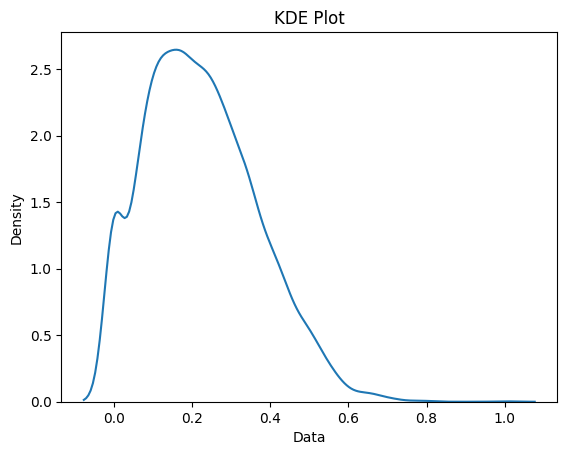

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample list of data (replace this with your actual data)
# data_list = [3.5, 2.1, 1.8, 4.3, 3.9, 2.5, 3.2, 2.7, 3.6, 3.0, 1.9, 2.8, 3.4]

# Create the KDE plot using seaborn
sns.kdeplot([x[0] for x in score_pct])

# Set plot labels and title
plt.xlabel('Data')
plt.ylabel('Density')
plt.title('KDE Plot')

# Display the plot
plt.show()

In [37]:
score_pct_thresh = 0.45
tgt_scores = [x for x in score_pct if x[0] > score_pct_thresh]
print(len(tgt_scores), len(score_pct), float(len(tgt_scores))/len(score_pct))
tgt_pseudo_label_imgs = [x[1] for x in score_pct if x[0]>score_pct_thresh]
print(np.mean([x[2] for x in score_pct if x[0]>score_pct_thresh]))
print(len(tgt_pseudo_label_imgs))

370 5388 0.06867112100965107
14.545945945945945
370


In [17]:
import shutil

output_dir = f'{base_path}/{base_data_dir}/{base_data_name}{pseudo_label_name}_mmdet_fold_0'
orig_dir = f'{base_path}/{base_data_dir}/all_dataset_mmdet_fold_0'
pseudo_label_all_imgs = False
tgt_pseudo_label_imgs = tgt_pseudo_label_imgs if not pseudo_label_all_imgs else os.listdir(f'{output_dir}/train_images')

if os.path.isdir(f'{output_dir}/validation_images'):
    shutil.rmtree(f'{output_dir}/validation_images')
os.mkdir(f'{output_dir}/validation_images')

remove_pseudo_label_imgs = set(os.listdir(f'{output_dir}/train_images')) - set(tgt_pseudo_label_imgs)
for train_img in remove_pseudo_label_imgs:
    os.remove(f'{output_dir}/train_images/{train_img}')

for train_img in os.listdir(f'{orig_dir}/train_images'):
    shutil.copyfile(f'{orig_dir}/train_images/{train_img}', f'{output_dir}/train_images/{train_img}')
for val_img in os.listdir(f'{orig_dir}/validation_images'):
    shutil.copyfile(f'{orig_dir}/validation_images/{val_img}', f'{output_dir}/validation_images/{val_img}')
# shutil.copyfile(f'{orig_dir}/annotations/validation_annotations.json', f'{output_dir}/annotations/validation_annotations.json')

In [18]:
pseudo_thresh = 0.3
val_pseudo_label_pkl = f'val_preds_yolo_{pseudo_thresh}.pkl'

with open(f'{orig_dir}/annotations/validation_annotations.json', 'r') as f:
    validation_annotations = json.load(f)

validation_annotation_dicts = change_annotation_format(validation_annotations)
validation_annotations = {
    'categories': validation_annotations['categories'],
    'images': validation_annotations['images'],
    'annotations': validation_annotation_dicts
}
with open(f'{output_dir}/annotations/validation_annotations.json', 'w') as f:
    json.dump(validation_annotations, f)

with open(f'{orig_dir}/annotations/train_annotations.json', 'r') as f:
    train_annotations = json.load(f)

train_annotation_dicts = change_annotation_format(train_annotations)
train_annot_ids = [x['id'] for x in train_annotation_dicts]
# print('=================')
# print(train_annot_ids)
# print('================')

with open(f'{base_path}/project_mmdet/{val_pseudo_label_pkl}', 'rb') as f:
    pseudo_annotations = pickle.load(f)
pseudo_annotations = [x for x in pseudo_annotations if x['img_path'].split('/')[-1] in tgt_pseudo_label_imgs]
pseudo_imgs, pseudo_annotation_dicts = create_seg_annots_pred(pseudo_annotations, len(train_annotations['images']), len(train_annotation_dicts))
pseudo_annot_ids = [x['id'] for x in pseudo_annotation_dicts]
# print('=================')
# print(pseudo_annot_ids)
# print('================')

train_final_annots = {'categories': train_annotations['categories'], 
                    'images': train_annotations['images'] + pseudo_imgs, 
                    'annotations': train_annotation_dicts + pseudo_annotation_dicts}
with open(f'{output_dir}/annotations/train_annotations.json', 'w') as f:
    json.dump(train_final_annots, f)

In [19]:
output_dir = f'{base_path}/{base_data_dir}/{base_data_name}{pseudo_label_name}_mmdet_fold_0'
orig_dir = f'{base_path}/{base_data_dir}/all_dataset_mmdet_fold_0'
annots_file = f'{output_dir}/annotations/train_annotations.json'
with open(f'{output_dir}/annotations/train_annotations.json', 'r') as f:
    annots = json.loads(f.read())

In [32]:
img_files = set()
img_ids = set()
annot_ids = set()
scores = set()
for annot in annots['images']:
    img_files.add(annot['file_name'])
    img_ids.add(annot['id'])
    if annot['id'] == 1621:
        print(annot)
annot_img_ids = set()
num_annots = 0
for annot in annots['annotations']:
    annot_ids.add(annot['id'])
    annot_img_ids.add(annot['image_id'])
    scores.add(annot['score'])
    if annot['image_id'] == 1621:
        num_annots += 1
print(len(img_files), len(img_ids), len(annot_img_ids), len(annots['annotations']), len(scores), num_annots)

{'file_name': '8d4d668351c0.tif', 'height': 512, 'width': 512, 'id': 1621}
1792 1792 1783 19063 5381 8


In [21]:
img_ids - annot_img_ids

{126, 214, 429, 792, 798, 1018, 1167, 1202, 1356}

In [33]:
pseudo_thresh = 0.3
val_pseudo_label_pkl = f'val_preds_yolo_{pseudo_thresh}.pkl'
with open(f'{base_path}/project_mmdet/{val_pseudo_label_pkl}', 'rb') as f:
    pseudo_annotations = pickle.load(f)
for annot in pseudo_annotations:
    if annot['img_path'].split('/')[-1] == '8d4d668351c0.tif':
        print(annot['bboxes'].shape[0])

8


In [ ]:
def create_seg_annots_pred(tgt_tile_dicts):
    for tile_dict in tgt_tile_dicts:
        cur_img_name = tile_dict['img_path'].split('/')[-1].split('.')[0]
        annotations = []
        annot_id = 0
        for label, bbox in zip(tile_dict['labels'].tolist(), tile_dict['bboxes'].tolist()):
            annotations.append({'iscrowd': 0, 'image_id': cur_img_name, 'bbox': bbox, 'category_id': label, 'id': annot_id})
            annot_id += 1
    return annotations

In [ ]:
i = 1
with open(f'{base_path}/{base_data_dir}/{base_data_name}_mmdet_fold_{i}/annotations/train_annotations.json', 'r') as f:
    train_annots = json.load(f)
with open(f'{base_path}/{base_data_dir}/{base_data_name}_mmdet_fold_{i}/annotations/validation_annotations.json', 'r') as f:
    validation_annots = json.load(f)

In [ ]:
train_annots.keys()

In [ ]:
img_to_segs = dict()

for annot in train_annots['annotations']:
    image_id = annot['image_id']
    segmentation = annot['segmentation'][0]
    if image_id not in img_to_segs:
        img_to_segs[image_id] = [segmentation]
    else:
        img_to_segs[image_id].append(segmentation)
for image_id in img_to_segs.keys():
    segmentations = img_to_segs[image_id]
    if len(segmentations) > 0:
        for i in range(len(segmentations)):
            for j in range(i+1, len(segmentations)):
                if segmentations[i]==segmentations[j]:
                    print(f'Found duplicate annots for image {image_id}!!!')

In [ ]:
categories = set()
train_img_ids = set()
train_seg_img_ids = set()
for annot in train_annots['images']:
    train_img_ids.add(annot['id'])
for annot in train_annots['annotations']:
    train_seg_img_ids.add(annot['image_id'])
    categories.add(annot['category_id'])
print(categories)

In [ ]:
categories = set()
validation_img_ids = set()
validation_seg_img_ids = set()
for annot in validation_annots['images']:
    validation_img_ids.add(annot['id'])
for annot in validation_annots['annotations']:
    validation_seg_img_ids.add(annot['image_id'])
    categories.add(annot['category_id'])
print(categories)

In [ ]:
len(train_img_ids), len(validation_img_ids)

In [ ]:
i=0
train_imgs_dir = f'{base_path}/{base_data_dir}/{base_data_name}_train_mmdet_fold_{i}/images'
train_img_files = os.listdir(train_imgs_dir)
